In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from time import perf_counter, sleep

### Fetching and Preprocessing

In [2]:
(data_train, data_test), data_info = tfds.load("fashion_mnist", as_supervised=True, split=["train", "test"], with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteNCMQ84/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteNCMQ84/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# First we have to normalise the sample images to a range
# between 0 and 1 (by dividing thru the maximum which is 255 for RGB)
data_train = data_train.map(lambda sample, label: (tf.cast(sample / 255, tf.float32), label))
data_test = data_test.map(lambda sample, label: (tf.cast(sample / 255, tf.float32), label))

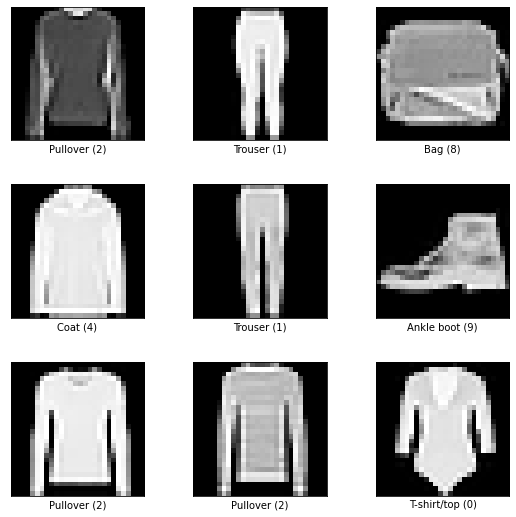

In [4]:
fig = tfds.show_examples(data_train, data_info)

In [5]:
batch_size = 64

# We start by prefetching the data (The amout of samples to prefetch,
# will be left to the framework)
data_train = data_train.prefetch(tf.data.experimental.AUTOTUNE)
data_test = data_test.prefetch(tf.data.experimental.AUTOTUNE)

# Afterwards we will cache the data, so that we don't have to wait for normalising and
# onehot encoding if we do a second training run 
data_train = data_train.cache()
data_test = data_test.cache()

# Now the data will be shuffled and batched afterwards.
# Shuffeling before batching seems more reasonable, because that way we don't
# get the same batch with different internal order each training, but completely different
# batches instead.
data_train = data_train.shuffle(10000)
data_test = data_test.shuffle(10000)
data_train = data_train.batch(batch_size)
data_test = data_test.batch(batch_size)

### Convolutional Autoencoder

##### The Model(s)

In [6]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()

    self.encoder = []
    self.encoder.append(layers.Conv2D(32, (3,3), activation="relu", padding="same", strides=2, input_shape=(28,28,1)))
    self.encoder.append(layers.Conv2D(16, (3,3), activation="relu", padding="same", strides=2))
    self.encoder.append(layers.Conv2D(8, (3,3), activation="relu", padding="same", strides=2))

    # self.encoder = []
    # self.encoder.append(layers.Conv2D(16, (3,3), activation="relu", padding="same", strides=2, input_shape=(28,28,1)))
    # self.encoder.append(layers.Conv2D(8, (3,3), activation="relu", padding="same", strides=2))


  @tf.function
  def call(self, x):
    for layer in self.encoder:
      x = layer(x)
      
    return x


class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()

    self.decoder = []
    self.decoder.append(layers.Conv2DTranspose(8, 3, activation="relu", padding="same", strides=2, output_padding=0))
    self.decoder.append(layers.Conv2DTranspose(16, 3, activation="relu", padding="same", strides=2, output_padding=1))
    self.decoder.append(layers.Conv2DTranspose(32, 3, activation="relu", padding="same", strides=2, output_padding=1))
    self.decoder.append(layers.Conv2D(1, (3,3), activation="sigmoid", padding="same"))

    # self.decoder = []
    # self.decoder.append(layers.Conv2DTranspose(8, 3, activation="relu", padding="same", strides=2))
    # self.decoder.append(layers.Conv2DTranspose(16, 3, activation="relu", padding="same", strides=2))
    # self.decoder.append(layers.Conv2D(1, (3,3), activation="sigmoid", padding="same"))


  @tf.function
  def call(self, x):
    for layer in self.decoder:
      x = layer(x)
      
    return x


class Conv_Autoencoder(tf.keras.Model):
  def __init__(self):
    super(Conv_Autoencoder, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  @tf.function
  def call(self, x):
    x_encoded = self.encoder(x)
    x_decoded = self.decoder(x_encoded)

    return x_decoded

##### Training

In [7]:
def train_step(model, input, loss_function, optimizer):
  # Train the model using gradient tape and return the loss for visualisation
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(input, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss 

def test(model, test_data, loss_function):
  # Get loss of a dataset
  test_loss_aggregator = []

  for (input, _) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(input, prediction)

    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = np.mean(test_loss_aggregator)

  return test_loss

def train_model(num_epochs, learning_rate, model):
  tf.keras.backend.clear_session()

  # Initialise the loss function for training (Mean Squared Error seems to work quite well here)
  mean_squared_error = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  train_losses, test_losses = [],[]

  # Get the initial losses
  start = perf_counter()
  test_loss = test(model, data_test, mean_squared_error)
  test_losses.append(test_loss)
  train_loss = test(model, data_train, mean_squared_error)
  train_losses.append(train_loss)

  print((f"Init:" + " " *(len(str(num_epochs)) + 3) + ""
         f"  Loss: (Train: {'{0:.3f}'.format(round(float(train_losses[-1]), 3))},"
         f"  Test: {'{0:.3f}'.format(round(float(test_loss), 3))}),"
         f"  Overfitting Indicator: {'{0:+.3f}'.format(round(float(test_losses[-1] - train_losses[-1]), 3))},"
         f"  Time: {'{0:.2f}'.format(round(perf_counter() - start, 2))}s"))


  # TODO: What are these warnings??
  tf.get_logger().setLevel("ERROR")

  # Train the model (record the time as well for performance judgements)
  for epoch in range(1, num_epochs + 1):
      start = perf_counter()

      average = []
      for (input,_) in data_train:
          train_loss = train_step(model, input, mean_squared_error, optimizer)
          average.append(train_loss)
          
      train_losses.append(np.mean(average))
      
      test_loss = test(model, data_test, mean_squared_error)
      test_losses.append(test_loss)

      print((f"Epoch #{epoch}:" + " " * (len(str(num_epochs)) - len(str(epoch)))+ ""
             f"  Loss: (Train: {'{0:.3f}'.format(round(float(train_losses[-1]), 3))},"
             f"  Test: {'{0:.3f}'.format(round(float(test_loss), 3))}),"
             f"  Overfitting Indicator: {'{0:+.3f}'.format(round(float(test_losses[-1] - train_losses[-1]), 3))},"
             f"  Time: {'{0:.2f}'.format(round(perf_counter() - start, 2))}s"))
      
  return train_losses, test_losses

def plot_learning(train_losses, test_losses, num_epochs):
  # draw the loss plot
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend((line1, line2), ("training", "test"))
  plt.show()

Init:       Loss: (Train: 0.170,  Test: 0.170),  Overfitting Indicator: -0.001,  Time: 17.14s
Epoch #1:   Loss: (Train: 0.014,  Test: 0.009),  Overfitting Indicator: -0.005,  Time: 9.35s
Epoch #2:   Loss: (Train: 0.008,  Test: 0.007),  Overfitting Indicator: -0.001,  Time: 8.87s
Epoch #3:   Loss: (Train: 0.007,  Test: 0.007),  Overfitting Indicator: -0.000,  Time: 8.89s
Epoch #4:   Loss: (Train: 0.006,  Test: 0.007),  Overfitting Indicator: +0.000,  Time: 8.88s
Epoch #5:   Loss: (Train: 0.006,  Test: 0.006),  Overfitting Indicator: -0.000,  Time: 8.89s
Epoch #6:   Loss: (Train: 0.006,  Test: 0.006),  Overfitting Indicator: +0.000,  Time: 8.87s
Epoch #7:   Loss: (Train: 0.006,  Test: 0.007),  Overfitting Indicator: +0.001,  Time: 8.86s
Epoch #8:   Loss: (Train: 0.006,  Test: 0.006),  Overfitting Indicator: -0.000,  Time: 8.89s
Epoch #9:   Loss: (Train: 0.006,  Test: 0.006),  Overfitting Indicator: -0.000,  Time: 8.88s
Epoch #10:  Loss: (Train: 0.006,  Test: 0.006),  Overfitting Indicato

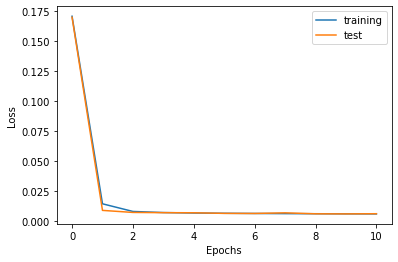

In [8]:
num_epochs = 10
learning_rate = 0.01
conv_autoencoder = Conv_Autoencoder()

train_losses, test_losses = train_model(num_epochs, learning_rate, conv_autoencoder)

plot_learning(train_losses, test_losses, num_epochs)

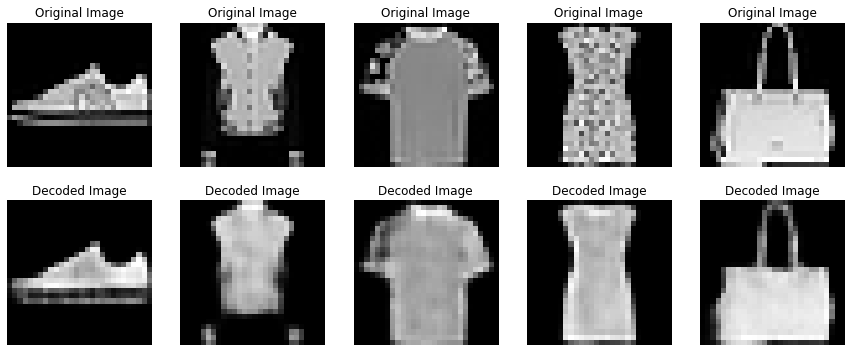

In [9]:
# Here we plot 5 samples before and after encoding/decoding

sample_images = data_test.take(1)

for batch in sample_images:
  samples_encoded = conv_autoencoder.encoder(batch[0])
  samples_decoded = conv_autoencoder.decoder(samples_encoded)
  
  fig = plt.figure(1)
  fig.set_figheight(6)
  fig.set_figwidth(15)
  for i, sample in enumerate(batch[0][:5], 1):
    plt.subplot(2, 5, i)
    plt.imshow(sample.numpy().squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 5, i + 5)
    plt.imshow(samples_decoded[i - 1].numpy().squeeze(), cmap='gray')
    plt.title("Decoded Image")
    plt.axis('off')

plt.show()

##### t-SNE

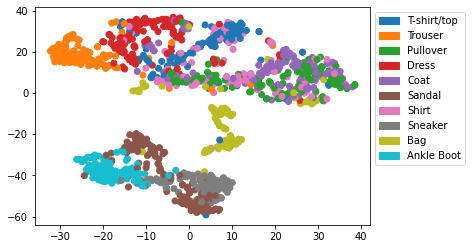

In [10]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# To get a nice legend which shows us which color stands for which clothing piece
# we create the mappings for the legend
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
        5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

patches = [mpatches.Patch(color=str(f"C{key}"), label=labels[key]) for key in labels]

# We unbatch the data and batch it in 1000 batches again, so that we can change the training 
# batch as much as we want so that it doesn't interfere here
batch = data_test.unbatch().batch(1000).take(1)

tsne = TSNE(n_components=2, random_state=0)

for samples in batch:
  # Firstly we encode all the samples
  samples_encoded = conv_autoencoder.encoder(samples[0]).numpy()

  # Due to tsne needing a two dimensional array we have to reduce the values of each 
  # encoding into one dimension (the other is necessary to hold all the samples together)
  nsamples, x, y, z = samples_encoded.shape
  d2_samples_encoded = samples_encoded.reshape((nsamples, x*y*z))

  # Now we let tSNE do its magic and plot the results
  samples_tsne = tsne.fit_transform(d2_samples_encoded)
  plt.scatter(samples_tsne[:,0], samples_tsne[:,1], c = [f"C{l}" for l in samples[1]])
  plt.legend(handles=patches, loc="upper left", bbox_to_anchor = (1, 1))
  plt.show()